# **Taxi Dynamic Pricing System **   
Team Number: DC19022 - 1st March 2019
____________________________________________________________________________________________________________________________________________

## 1. Data Processing

### a. Load Data
First of all, we concatenate all 12 files into a total dataset file, solving wrong placement of delimiter. The total dataset file contain 12 months’ data, which is over 4 GB. In order to handle this huge dataset file, we upload it to Kaggle for future processing.

In [1]:
#Call required libraries
import numpy as np            # Data manipulation
from numpy import nan as NA
import pandas as pd           # Dataframe manipulatio 
from pandas import DataFrame
import matplotlib.pyplot as plt
import os
import conda
import seaborn as sns
from sklearn.cluster import KMeans #For clustering

In [2]:
# Load data
taxi_df = pd.read_csv('../input/taxi_final.csv', delimiter = ',', low_memory = True )

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,5,15,19,22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### b. Basic Check of data

In [3]:
# Column names
taxi_df.columns

Index(['Type', 'PROVIDER NAME', 'StartDateTime', 'DateCreated', 'ID',
       'ExternalID', 'FareAmount', 'GratuityAmount', 'SurchargeAmount',
       'ExtraFareAmount', 'TollAmount', 'TotalAmount', 'PaymentType',
       'StartDateTime.1', 'EndDateTime', 'OriginStreetNumber',
       'OriginStreetName', 'OriginCity', 'OriginState', 'OriginZip',
       'OriginLatitude', 'OriginLongitude', 'DestinationStreetNumber',
       'DestinationStreetName', 'DestinationCity', 'DestinationState',
       'DestinationZip', 'DestinationLatitude', 'DestinationLongitude',
       'Milage', 'Duration', 'Unnamed: 31'],
      dtype='object')

In [4]:
# Basic information about dataset
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11937645 entries, 0 to 11937644
Data columns (total 32 columns):
Type                       object
PROVIDER NAME              object
StartDateTime              object
DateCreated                object
ID                         object
ExternalID                 object
FareAmount                 float64
GratuityAmount             float64
SurchargeAmount            float64
ExtraFareAmount            float64
TollAmount                 float64
TotalAmount                float64
PaymentType                float64
StartDateTime.1            object
EndDateTime                object
OriginStreetNumber         object
OriginStreetName           object
OriginCity                 object
OriginState                object
OriginZip                  object
OriginLatitude             float64
OriginLongitude            float64
DestinationStreetNumber    object
DestinationStreetName      object
DestinationCity            object
DestinationState          

In [5]:
# Drop useless columns
taxi_df.drop(['DateCreated', 'StartDateTime.1', 'Unnamed: 31'], axis=1, inplace=True)

In [6]:
# Remove nulls and wrong values
taxi_df = taxi_df[taxi_df['FareAmount'] > 0]
taxi_df = taxi_df[taxi_df['GratuityAmount'] >= 0]
taxi_df = taxi_df[taxi_df['SurchargeAmount'] >= 0]
taxi_df = taxi_df[taxi_df['ExtraFareAmount'] >= 0]
taxi_df = taxi_df[taxi_df['TotalAmount'] > 0]
taxi_df = taxi_df[taxi_df['Milage'] > 0]
taxi_df = taxi_df[taxi_df['Milage'] < 500]

## 2. EDA

In [7]:
taxi_df['FareAmount'].groupby(taxi_df['PROVIDER NAME']).sum()

PROVIDER NAME
Bay Cab            7.208548e+06
CMT                2.286637e+07
Capitol Cab        7.251145e+05
DC VIP Cab         1.686416e+07
Grand Cab          3.523022e+06
Hitch              1.878349e+07
My taxi Control    4.505555e+05
Transco            1.779673e+07
UVC                2.686196e+07
VeriFone           1.351136e+07
Yellow Cab         1.057036e+07
Name: FareAmount, dtype: float64

In [8]:
# Change data format
taxi_df['StartDateTime'] = pd.to_datetime(taxi_df['StartDateTime'], errors='coerce')
taxi_df['EndDateTime'] = pd.to_datetime(taxi_df['EndDateTime'])

# Generate detailed columns of datetime
taxi_df['Date'] = taxi_df['StartDateTime'].dt.date
taxi_df['Hour'] = taxi_df['StartDateTime'].dt.hour
taxi_df['Weekday'] = taxi_df['StartDateTime'].dt.weekday
taxi_df['DayofWeek'] = taxi_df['StartDateTime'].dt.weekday_name

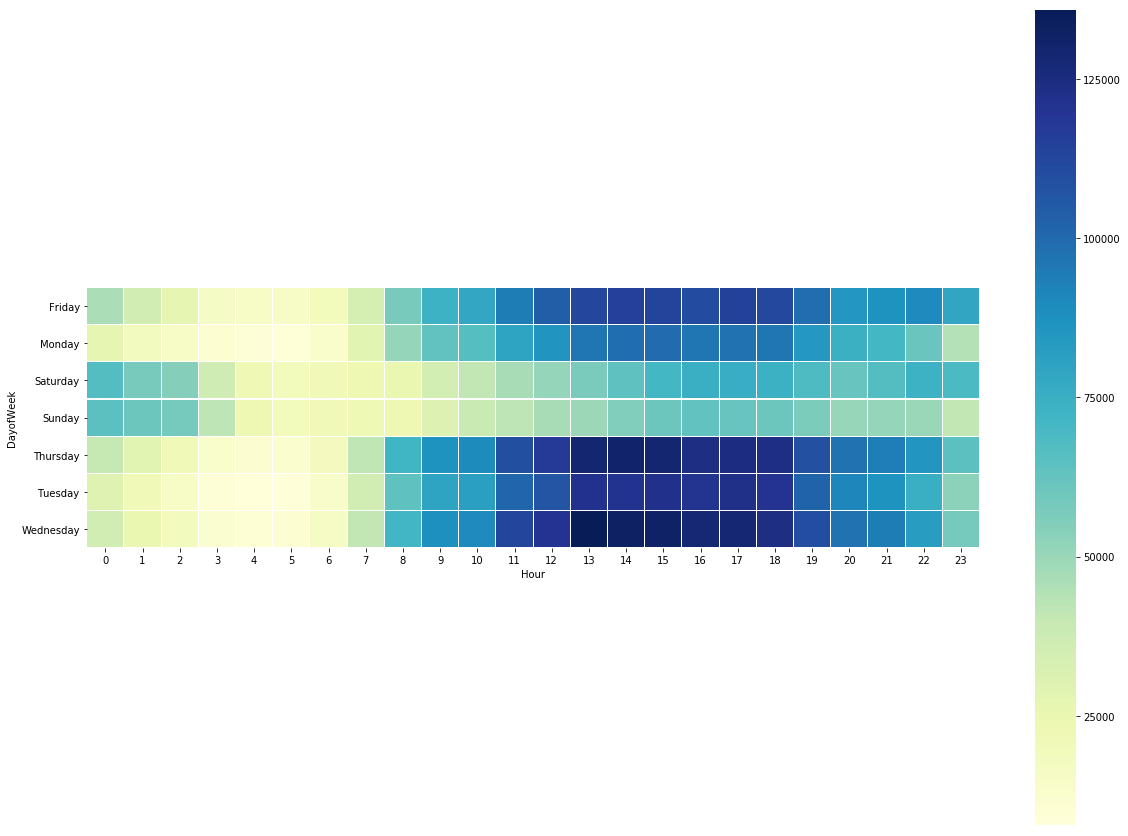

In [9]:
# Plot the heat map
time_map=pd.pivot_table(taxi_df,index=['DayofWeek'],columns =['Hour'],aggfunc='size')
fig, ax = plt.subplots(figsize=(20,15)) 
ax=sns.heatmap(time_map,linewidths=0.1,square=True,cmap='YlGnBu')

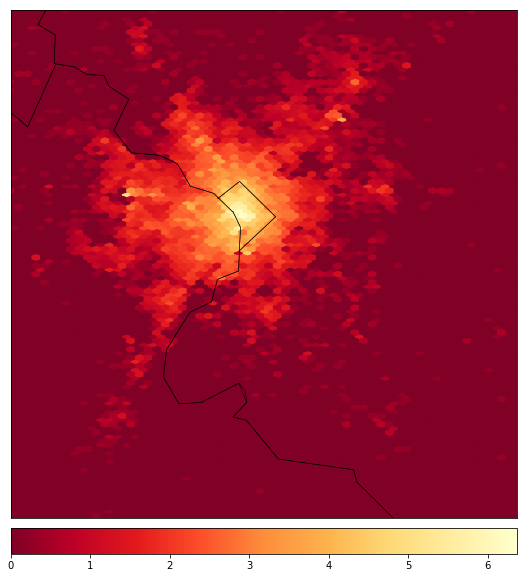

In [10]:
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
west, south, east, north = -77.87, 38.00, -76.00, 39.5
fig = plt.figure(figsize=(14,10))
m = Basemap(projection='tmerc', llcrnrlat=south, urcrnrlat=north,
            llcrnrlon=west, urcrnrlon=east, lat_0=38.00,lon_0=-76.00, resolution='i')
m.drawstates()
x, y = m(taxi_df['DestinationLongitude'].values, taxi_df['DestinationLatitude'].values)
m.hexbin(x, y, gridsize=6000, bins='log',cmap=cm.YlOrRd_r)
m.colorbar(location='bottom')

In [11]:
# Classify weekdays and weekend
x = 0
taxi_df['IsWeekday'] = [x+1 if i<6 else x for i in taxi_df['Weekday']]

In [12]:
# Remove nulls and wrong values
taxi_df['StartDateTime'].dropna(inplace=True)
taxi_df = taxi_df[taxi_df['StartDateTime'] < taxi_df['EndDateTime']]

## 2. Time clustering   
To label each hour in a day with off-peak-normal-peak, we apply **K-Means clustering** in python with scikit-learn. In the process of cleaning data, we remove the null and wrong data from dataset. Due to the different pattern between weekdays and weekend, we divide total dataset into two parts and develop clustering models separately. As a result, we found that peak time is 12-19 am and the off-peak time is 0-7 am on weekdays. For weekend, the peak time is 0-2 am and 14-19 am, and the off-peak time is 4-9 am.

In [13]:
# Label Weekdays
df1 = DataFrame(taxi_df[taxi_df['IsWeekday']==1]['Hour'].value_counts().sort_index())
df1 = df1.reset_index()
df1.columns = ['Hour', 'Demand']

kmeans = KMeans(n_clusters=3, random_state=0).fit(df1)
df1['WeekdayLabel'] = kmeans.labels_

In [14]:
# Weekdays time tiers
df1

,Hour,Demand,WeekdayLabel
0,0,238728,0
1,1,180951,0
2,2,147825,0
3,3,95847,0
4,4,69786,0
5,5,69082,0
6,6,93402,0
7,7,186760,0
8,8,317531,2
9,9,401168,2


In [15]:
# Label Weekend
df2 = DataFrame(taxi_df[taxi_df['IsWeekday']==0]['Hour'].value_counts().sort_index())
df2 = df2.reset_index()
df2.columns = ['Hour', 'Demand']

kmeans = KMeans(n_clusters=3, random_state=0).fit(df2)
df2['WeekendLabel'] = kmeans.labels_

In [16]:
# Weekend time tiers
df2

,Hour,Demand,WeekendLabel
0,0,62593,2
1,1,58798,2
2,2,56643,2
3,3,40966,0
4,4,22627,1
5,5,18693,1
6,6,19682,1
7,7,20560,1
8,8,21036,1
9,9,28325,1


In [17]:
# Merge labels
df1 = df1.loc[:,['Hour', 'WeekdayLabel']]
df2 = df2.loc[:,['Hour', 'WeekendLabel']]

In [18]:
taxi_df = taxi_df.merge(df1, on = 'Hour')

In [19]:
taxi_df = taxi_df.merge(df2, on = 'Hour')

## 3. Price Optimization for peak time

In [20]:
taxi_df.columns

Index(['Type', 'PROVIDER NAME', 'StartDateTime', 'ID', 'ExternalID',
       'FareAmount', 'GratuityAmount', 'SurchargeAmount', 'ExtraFareAmount',
       'TollAmount', 'TotalAmount', 'PaymentType', 'EndDateTime',
       'OriginStreetNumber', 'OriginStreetName', 'OriginCity', 'OriginState',
       'OriginZip', 'OriginLatitude', 'OriginLongitude',
       'DestinationStreetNumber', 'DestinationStreetName', 'DestinationCity',
       'DestinationState', 'DestinationZip', 'DestinationLatitude',
       'DestinationLongitude', 'Milage', 'Duration', 'Date', 'Hour', 'Weekday',
       'DayofWeek', 'IsWeekday', 'WeekdayLabel', 'WeekendLabel'],
      dtype='object')

In [21]:
# Split dataset into weekdays data and weekend data
day_df = taxi_df[taxi_df['IsWeekday']==1].loc[:,['FareAmount', 'TotalAmount', 'IsWeekday', 'WeekdayLabel']]
end_df = taxi_df[taxi_df['IsWeekday']==0].loc[:,['FareAmount', 'TotalAmount', 'IsWeekday', 'WeekendLabel']]

In [22]:
# For weekdays
peak = day_df[day_df['WeekdayLabel']==1]
off_peak = day_df[day_df['WeekdayLabel']==0]

In [23]:
# For weekend
peak_end = end_df[end_df['WeekendLabel']==2]
off_peak_end = end_df[end_df['WeekendLabel']==1]

### a. Based on TotalAmount

In [24]:
# Generate list of price shift and demand shift
elastic = 0.22
price_shift = np.linspace(0.01,2,200)
demand_shift = price_shift * elastic
shift = list(zip(price_shift, demand_shift))

In [25]:
# Weekday, Based on TotalAmount
rev_day = []
for x,y in shift:
    peak_samp = peak.sample(frac=(1-y), random_state=1)
    p = peak_samp['TotalAmount'].sum() * (1 + x)
    rev_day.append(p)

In [26]:
# Weekday Peak time, Result, Based on TotalAmount
rev_day = DataFrame(list(zip(price_shift, demand_shift, rev_day)), columns=['price_shift', 'demand_shift', 'revenue'])
peak_day_max = rev_day.sort_values(by='revenue', ascending=False).head(1)

In [27]:
peak_day_max['revenue shift']= max(rev_day['revenue'])/peak['TotalAmount'].sum()-1
peak_day_max

,price_shift,demand_shift,revenue,revenue shift
163,1.64,0.3608,1.256383e+08,0.695778


In [28]:
# Weekend, Based on TotalAmount
rev_end = []
for x,y in shift:
    peak_end_samp = peak_end.sample(frac=(1-y), random_state=1)
    p = peak_end_samp['TotalAmount'].sum() * (1 + x)
    rev_end.append(p)

In [29]:
# Weekend Peak time, Result, Based on TotalAmount
rev_end = DataFrame(list(zip(price_shift, demand_shift, rev_end)), columns=['price_shift', 'demand_shift', 'revenue'])
peak_end_max = rev_end.sort_values(by='revenue', ascending=False).head(1)

In [30]:
peak_end_max['revenue shift']= max(rev_end['revenue'])/peak_end['TotalAmount'].sum()-1
peak_end_max

,price_shift,demand_shift,revenue,revenue shift
175,1.76,0.3872,1.340082e+07,0.693496


### b. Based on FareAmount

In [31]:
# Weekdays, Generat a related list of demand shift, based on fare shift
elastic = 0.22
fare_shift = np.linspace(0.01,2,200)
demand_shift_day = []
for i in fare_shift:
    a = (sum(peak['TotalAmount'] + peak['FareAmount'] * i)/sum(peak['TotalAmount']) - 1)*elastic
    demand_shift_day.append(a)

In [32]:
#Weekday High Peak, Analysis, only fare
shift_day = list(zip(fare_shift, demand_shift))
rev_day2 = []
for x,y in shift_day:
    peak_samp2 = peak.sample(frac=(1-y), random_state=1)
    p = sum(peak_samp2['TotalAmount'] + peak_samp2['FareAmount'] * x)
    rev_day2.append(p)

In [33]:
# Weekday Peak time, Result, Based on FareAmount
rev_day2 = DataFrame(list(zip(fare_shift, demand_shift, rev_day2)), columns=['fare_shift', 'demand_shift', 'revenue'])
peak_day_max2 = rev_day2.sort_values(by='revenue', ascending=False).head(1)

In [34]:
peak_day_max2['revenue shift']= max(rev_day2['revenue'])/peak['TotalAmount'].sum()-1
peak_day_max2

,fare_shift,demand_shift,revenue,revenue shift
163,1.64,0.3608,1.130761e+08,0.526223


In [35]:
# Weekend, Generat a related list of demand shift, based on fare shift
demand_shift_end = []
for i in fare_shift:
    a = (sum(peak_end['TotalAmount'] + peak_end['FareAmount'] * i)/sum(peak_end['TotalAmount']) - 1)*elastic
    demand_shift_end.append(a)

In [36]:
#Weekend High Peak, Analysis, Based on FareAmount
shift_end = list(zip(fare_shift, demand_shift_end))
rev_end2 = []
for x,y in shift_end:
    peak_end_samp2 = peak_end.sample(frac=(1-y), random_state=1)
    p = sum(peak_end_samp2['TotalAmount'] + peak_end_samp2['FareAmount'] * x)
    rev_end2.append(p)

In [37]:
# Weekend Peak time, Result, Based on FareAmount
rev_end2 = DataFrame(list(zip(fare_shift, demand_shift_end, rev_end2)), columns=['fare_shift', 'demand_shift', 'revenue'])
peak_end_max2 = rev_end2.sort_values(by='revenue', ascending=False).head(1)

In [38]:
peak_end_max2['revenue shift']= max(rev_end2['revenue'])/peak_end['TotalAmount'].sum()-1
peak_end_max2

,fare_shift,demand_shift,revenue,revenue shift
199,2.0,0.370644,13384470.0,0.691429


## 4. Price Optimization for off-peak time

In [39]:
# Generate list of price shift and demand shift
elastic = 0.22
price_shift_off = np.linspace(-0.01,-1,100)
demand_shift_off = price_shift_off * elastic
shift_off = list(zip(price_shift_off, demand_shift_off))

In [40]:
#Weekday Off-peak, Analysis
rev_off_day = []
for x,y in shift_off:
    off_samp = off_peak.sample(frac=(1+y), random_state=1, replace=True)
    p = off_samp['TotalAmount'].sum() * (1 + x)
    rev_off_day.append(p)

In [41]:
# Weekday Off-peak time, Result, Based on TotalAmount
rev_off_day = DataFrame(list(zip(price_shift_off, demand_shift_off, rev_off_day)), columns=['price_shift', 'demand_shift', 'revenue'])
off_day_max = rev_off_day.sort_values(by='revenue', ascending=False).head(1)

<function matplotlib.pyplot.show(*args, **kw)>

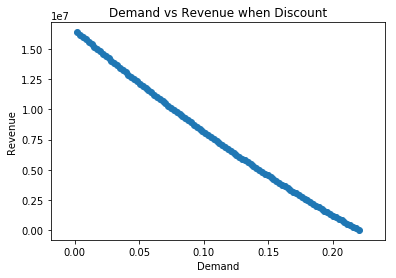

In [42]:
plt.scatter(-rev_off_day['demand_shift'], rev_off_day['revenue'])
plt.xlabel('Demand')
plt.ylabel('Revenue')
plt.title('Demand vs Revenue when Discount')
plt.show

In [43]:
#Weekend Off-peak, Analysis
rev_off_end = []
for x,y in shift_off:
    off_samp = off_peak_end.sample(frac=(1-y), random_state=1, replace=True)
    p = off_samp['TotalAmount'].sum() * (1 + x)
    rev_off_end.append(p)

In [44]:
# Weekday Off-peak time, Result, Based on TotalAmount
rev_off_end = DataFrame(list(zip(price_shift_off, demand_shift_off, rev_off_end)), columns=['price_shift', 'demand_shift', 'revenue'])
off_end_max = rev_off_end.sort_values(by='revenue', ascending=False).head(1)

<function matplotlib.pyplot.show(*args, **kw)>

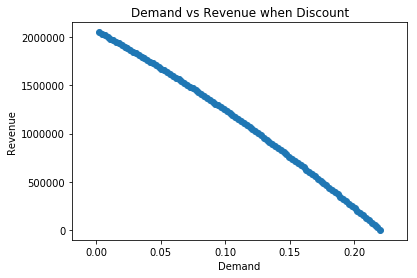

In [45]:
plt.scatter(-rev_off_end['demand_shift'], rev_off_end['revenue'])
plt.xlabel('Demand')
plt.ylabel('Revenue')
plt.title('Demand vs Revenue when Discount')
plt.show

## 5. TotalAmount per Trip

### a. Based on TotalAmount

In [46]:
# Set supply of Peak Time
s_elastic = 0.28
price_shift = np.linspace(0.01,2,200)
supply_shift = price_shift * s_elastic
supply_day = (1+supply_shift) * len(peak)
supply_end = (1+supply_shift) * len(peak_end)

In [47]:
#Weekday Peak Time, Result, per supply
rev_day['supply'] = supply_day
rev_day['TotalAmount per Trip'] = rev_day['revenue']/rev_day['supply']
p_mean = peak['TotalAmount'].mean()
print('Original amount per trip(Weekday):', p_mean)
print('Max amount per trip(Weekday):', rev_day['TotalAmount per Trip'].max())
print('Price shift(Weekday):', rev_day['TotalAmount per Trip'].max()/p_mean -1)

Original amount per trip(Weekday): 15.085502480732021
Max amount per trip(Weekday): 18.41980268311402
Price shift(Weekday): 0.22102679089680577


In [48]:
#Weekend Peak Time, Result, per supply
rev_end['supply'] = supply_end
rev_end['TotalAmount per Trip'] = rev_end['revenue']/rev_end['supply']
print('Original amount per trip(Weekend):', peak_end['TotalAmount'].mean())
print('Max amount per trip(Weekend):', rev_end['TotalAmount per Trip'].max())
print('Price shift(Weekend):', rev_day['TotalAmount per Trip'].max()/peak_end['TotalAmount'].mean() -1)

Original amount per trip(Weekend): 15.162938460007394
Max amount per trip(Weekend): 18.50280360893093
Price shift(Weekend): 0.21479109947565123


### b. Based on FareAmount

In [49]:
# Set supply of Peak Time for Weekdays
supply_shift_day = np.array(demand_shift_day)  * (s_elastic/elastic)
supply_day2 = (1+supply_shift_day) * len(peak)

In [50]:
#Weekday Peak Time, Result, per supply
rev_day2['supply'] = supply_day2
rev_day2['TotalAmount per Trip'] = rev_day2['revenue']/rev_day['supply']
print('Original amount per trip(Weekday):', p_mean)
print('Max amount per trip(Weekday):', rev_day2['TotalAmount per Trip'].max())
print('Price shift(Weekday):', rev_day2['TotalAmount per Trip'].max()/p_mean -1)

Original amount per trip(Weekday): 15.085502480732021
Max amount per trip(Weekday): 17.014303152133728
Price shift(Weekday): 0.12785790024994337


In [51]:
# Set supply of Peak Time for Weekend
supply_shift_end = np.array(demand_shift_end)  * (s_elastic/elastic)
supply_end2 = (1+supply_shift_end) * len(peak_end)

In [52]:
#Weekend Peak Time, Result, per supply
rev_end2['supply'] = supply_end2
rev_end2['TotalAmount per Trip'] = rev_end2['revenue']/rev_end2['supply']
print('Original amount per trip(Weekend):', peak_end['TotalAmount'].mean())
print('Max amount per trip(Weekend):', rev_end2['TotalAmount per Trip'].max())
print('Price shift(Weekend):', rev_end2['TotalAmount per Trip'].max()/peak_end['TotalAmount'].mean() -1)

Original amount per trip(Weekend): 15.162938460007394
Max amount per trip(Weekend): 18.499184871942504
Price shift(Weekend): 0.22002637686188176
